----

# Descripción

La compañía de seguros Sure Tomorrow quiere resolver varias tareas con la ayuda de machine learning y te pide que evalúes esa posibilidad.
- Tarea 1: encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.
- Tarea 2: predecir la probabilidad de que un nuevo cliente reciba una prestación del seguro. ¿Puede un modelo de predictivo funcionar mejor que un modelo dummy?
- Tarea 3: predecir el número de prestaciones de seguro que un nuevo cliente pueda recibir utilizando un modelo de regresión lineal.
- Tarea 4: proteger los datos personales de los clientes sin afectar al modelo del ejercicio anterior. Es necesario desarrollar un algoritmo de transformación de datos que dificulte la recuperación de la información personal si los datos caen en manos equivocadas. Esto se denomina enmascaramiento u ofuscación de datos. Pero los datos deben protegerse de tal manera que no se vea afectada la calidad de los modelos de machine learning. No es necesario elegir el mejor modelo, basta con demostrar que el algoritmo funciona correctamente.


# Preprocesamiento y exploración de datos

## Inicialización

In [6]:
pip install scikit-learn --upgrade

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: scikit-learn in c:\users\administrador\anaconda3\lib\site-packages (1.2.2)



In [7]:
import os
import numpy as np
import pandas as pd
import math
import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier


from IPython.display import display

## Carga de datos

Carga los datos y haz una revisión básica para comprobar que no hay problemas obvios.

In [8]:
#->datos
# Leer el archivo y almacenarlo en df
def cargar_archivos_con_separadores(archivos_con_separadores):
    """
    Carga múltiples archivos CSV con separadores específicos para cada archivo y los almacena en un diccionario de DataFrames.
    
    :param archivos_con_separadores: Diccionario donde las claves son los nombres de los archivos y los valores son los separadores.
    :return: Diccionario con nombres de archivos como claves y DataFrames como valores.
    """
    df = {}  # Objeto que almacenará los DataFrames

    # Iterar sobre los archivos y sus separadores
    for archivo_nombre, separador in archivos_con_separadores.items():
        url_no_windows = '/datasets/' + archivo_nombre
        url_windows = 'datasets/' + archivo_nombre
        
        try:
            # Intentar cargar desde la ruta no-Windows
            if os.path.exists(url_no_windows):
                df[archivo_nombre] = pd.read_csv(url_no_windows, sep=separador, dtype={'votes': 'Int64'})
                print(f"Archivo cargado exitosamente desde '{url_no_windows}'")
            
            # Intentar cargar desde la ruta Windows
            elif os.path.exists(url_windows):
                df[archivo_nombre] = pd.read_csv(url_windows, sep=separador, dtype={'votes': 'Int64'})
                print(f"Archivo cargado exitosamente desde '{url_windows}'")
            
            else:
                raise FileNotFoundError(f"Error: el archivo '{archivo_nombre}' no se encuentra en ninguna de las rutas especificadas.")
        
        except FileNotFoundError as e:
            print(e)
        
        except pd.errors.ParserError as e:
            print(f"Error al procesar el archivo CSV '{archivo_nombre}': {e}")
        
        except Exception as e:
            print(f"Ha ocurrido un error inesperado con el archivo '{archivo_nombre}': {e}")

    return df

# Ejemplo de uso
archivos_con_separadores = {
    'insurance_us.csv': ',',    
}

# Cargar los archivos en el objeto df
df_all = cargar_archivos_con_separadores(archivos_con_separadores)

# El objeto df ahora contiene un DataFrame por cada archivo cargado
df = df_all.get('insurance_us.csv')


Archivo cargado exitosamente desde 'datasets/insurance_us.csv'


Renombramos las columnas para que el código se vea más coherente con su estilo.

In [9]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [10]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
2961,1,22.0,41500.0,1,0
4898,1,28.0,39800.0,0,0
1098,1,21.0,33800.0,0,0
3743,1,26.0,26500.0,2,0
3279,0,27.0,41500.0,0,0
4670,0,34.0,35500.0,1,0
2545,0,44.0,38800.0,0,1
4272,0,47.0,33000.0,4,1
2555,1,21.0,42200.0,0,0
2580,0,23.0,29000.0,2,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [12]:
# puede que queramos cambiar el tipo de edad (de float a int) aunque esto no es crucial

# escribe tu conversión aquí si lo deseas:

# Convertir la columna 'age' de float a int
df['age'] = df['age'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int32  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int32(1), int64(3)
memory usage: 175.9 KB


In [13]:
# ahora echa un vistazo a las estadísticas descriptivas de los datos.# ¿Se ve todo bien?

In [14]:
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


los datos pmbarcen estar en buen estado, seria pertinente revisar las columnas "age", "income" y "family_members", ya que podrian contener valores atipicos, dado a que la desviacion estandar de los datos es alta.

## Análisis exploratorio de datos

Vamos a comprobar rápidamente si existen determinados grupos de clientes observando el gráfico de pares.

c:\Users\Administrador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Administrador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Administrador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Administrador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert in

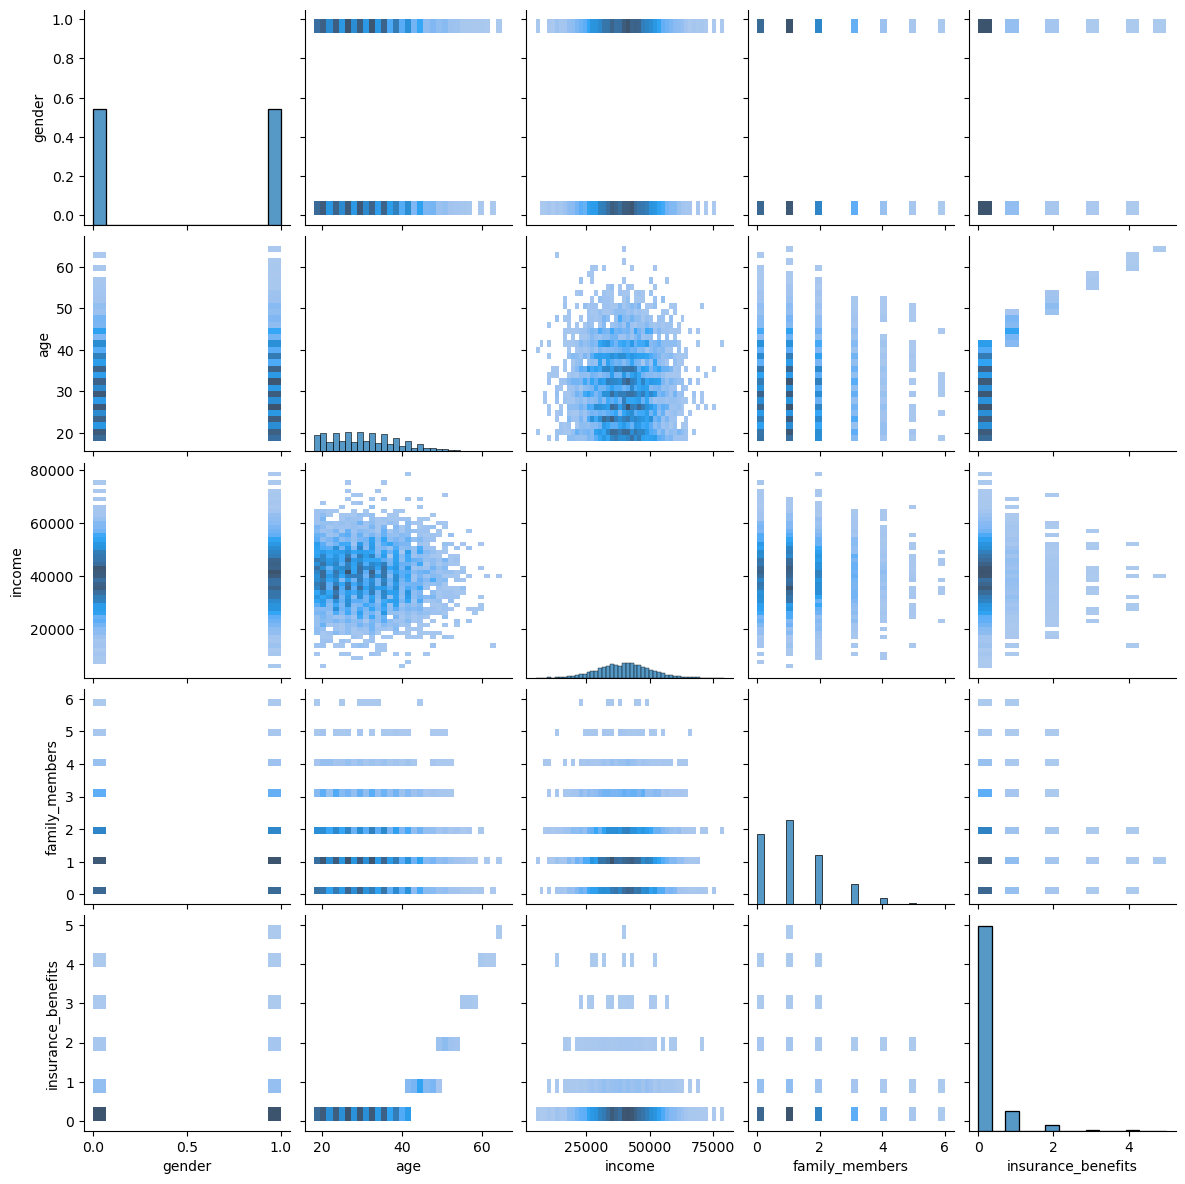

In [15]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

De acuerdo, es un poco complicado detectar grupos obvios (clústeres) ya que es difícil combinar diversas variables simultáneamente (para analizar distribuciones multivariadas). Ahí es donde LA y ML pueden ser bastante útiles.

# Tarea 1. Clientes similares

En el lenguaje de ML, es necesario desarrollar un procedimiento que devuelva los k vecinos más cercanos (objetos) para un objeto dado basándose en la distancia entre los objetos.
Es posible que quieras revisar las siguientes lecciones (capítulo -> lección)- Distancia entre vectores -> Distancia euclidiana
- Distancia entre vectores -> Distancia Manhattan

Para resolver la tarea, podemos probar diferentes métricas de distancia.

Escribe una función que devuelva los k vecinos más cercanos para un $n^{th}$ objeto basándose en una métrica de distancia especificada. A la hora de realizar esta tarea no debe tenerse en cuenta el número de prestaciones de seguro recibidas.
Puedes utilizar una implementación ya existente del algoritmo kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) o tu propia implementación.
Pruébalo para cuatro combinaciones de dos casos- Escalado
  - los datos no están escalados
  - los datos se escalan con el escalador [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)
- Métricas de distancia
  - Euclidiana
  - Manhattan

Responde a estas preguntas:- ¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?- ¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?

In [16]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [17]:
def get_knn(df, n, k, metric):
    
    """
    Devuelve los k vecinos más cercanos

    :param df: DataFrame de pandas utilizado para encontrar objetos similares dentro del mismo lugar    :param n: número de objetos para los que se buscan los vecinos más cercanos    :param k: número de vecinos más cercanos a devolver
    :param métrica: nombre de la métrica de distancia    """

    # Crear y ajustar el modelo NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=k, metric=metric)
    nbrs.fit(df[feature_names].values)
    
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Escalar datos.

In [18]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [19]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
1945,1,0.476923,0.463291,0.500000,0
3977,1,0.492308,0.526582,0.166667,0
2360,1,0.615385,0.554430,0.000000,0
2992,0,0.723077,0.479747,0.000000,1
2291,0,0.615385,0.344304,0.166667,0


Ahora, vamos a obtener registros similares para uno determinado, para cada combinación

In [20]:
# Probar la función get_knn con diferentes métricas y datos escalados
print("Vecinos más cercanos con datos escalados usando MaxAbsScaler:\n")

Vecinos más cercanos con datos escalados usando MaxAbsScaler:



In [21]:
print("Metrica Euclidiana:\n", get_knn(df_scaled, 0, 3, 'euclidean'))


Metrica Euclidiana:
       gender       age    income  family_members  insurance_benefits  distance
0          1  0.630769  0.627848        0.166667                   0  0.000000
2689       1  0.630769  0.634177        0.166667                   0  0.006329
133        1  0.615385  0.636709        0.166667                   0  0.017754


In [22]:
print("\nMetrica Manhattan:\n", get_knn(df_scaled, 0, 3, 'manhattan'))



Metrica Manhattan:
       gender       age    income  family_members  insurance_benefits  distance
0          1  0.630769  0.627848        0.166667                   0  0.000000
2689       1  0.630769  0.634177        0.166667                   0  0.006329
133        1  0.615385  0.636709        0.166667                   0  0.024245


Respuestas a las preguntas

**¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?** 

Si, pueden afectar significativamente y se manifiesta en: 

    1.- Diferentes escalas de caracteristicas, si alguna de ellas tiene distancias muy amplias, estas  caracteristicas se volveran dominantes sobre las de menos distancia entre ellas.
    2.- Distorsión de la metrica de distancia, ya que KNN calcula la distancia basandose en los valores de las caracteristicas y si no estan correctamente escaladas, pueden no reflejar correctamente los valores numericos.
    3.- Impacto en la efectividad, el algoritmo se basa en encontrar vecinos mas cercanos a un punto de consulta, si las distancias no son representativas a la proximidad real, el algoritmo no podra encontrar los vecinos mas cercanos de manera precisa.

**¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?** 

los resultados son similares, la diferencia recae en que la distancia Manhattan se obtiene sumando las difenrecias absolutas entre dos coordenadas, a diferencia de la distancia Euclidiana, que se obtiene calculando la longitud entre dos coordenadas, la distancia Manhattan es adecuada para atos que no estan distribuidos de manera uniforme.

 las distancias Manhanttan son generalmente mayores a la Euclidianas, es importante seleccionar la metrica de distancia adecuada segun los datos a analizar.

# Tarea 2. ¿Es probable que el cliente reciba una prestación del seguro?

En términos de machine learning podemos considerarlo como una tarea de clasificación binaria.

Con el valor de `insurance_benefits` superior a cero como objetivo, evalúa si el enfoque de clasificación kNN puede funcionar mejor que el modelo dummy.
Instrucciones:
- Construye un clasificador basado en KNN y mide su calidad con la métrica F1 para k=1...10 tanto para los datos originales como para los escalados. Sería interesante observar cómo k puede influir en la métrica de evaluación y si el escalado de los datos provoca alguna diferencia. Puedes utilizar una implementación ya existente del algoritmo de clasificación kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) o tu propia implementación.- Construye un modelo dummy que, en este caso, es simplemente un modelo aleatorio. Debería devolver "1" con cierta probabilidad. Probemos el modelo con cuatro valores de probabilidad: 0, la probabilidad de pagar cualquier prestación del seguro, 0.5, 1.
La probabilidad de pagar cualquier prestación del seguro puede definirse como
$$
P\{\text{prestación de seguro recibida}\}=\frac{\text{número de clientes que han recibido alguna prestación de seguro}}{\text{número total de clientes}}.
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30.

In [23]:
# сalcula el objetivo
df['insurance_benefits_received'] = df['insurance_benefits'] > 0

# Convertir la columna a tipo entero (0 o 1)
df['insurance_benefits_received'] = df['insurance_benefits_received'].astype(int)

In [24]:
# comprueba el desequilibrio de clases con value_counts()

# <tu código aquí>
# Contar las instancias de cada clase en la columna 'insurance_benefits_received'
class_counts = df['insurance_benefits_received'].value_counts()

# Mostrar el resultado
print(class_counts)


insurance_benefits_received
0    4436
1     564
Name: count, dtype: int64


In [25]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# si tienes algún problema con la siguiente línea, reinicia el kernel y ejecuta el cuaderno de nuevo    
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Matriz de confusión')
    print(cm)

In [26]:
# generar la salida de un modelo aleatorio

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [27]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'La probabilidad: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, size=len(df))
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

La probabilidad: 0.00
F1: 0.00
Matriz de confusión
[[0.8872 0.    ]
 [0.1128 0.    ]]

La probabilidad: 0.11
F1: 0.12
Matriz de confusión
[[0.7914 0.0958]
 [0.0994 0.0134]]

La probabilidad: 0.50
F1: 0.20
Matriz de confusión
[[0.456  0.4312]
 [0.053  0.0598]]

La probabilidad: 1.00
F1: 0.20
Matriz de confusión
[[0.     0.8872]
 [0.     0.1128]]



In [28]:
# Dividir los datos en entrenamiento y prueba
X = df[['gender', 'age', 'income', 'family_members']]
y = df['insurance_benefits_received']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [29]:
# Función para evaluar el rendimiento del clasificador KNN
def evaluate_knn(X_train, X_test, y_train, y_test, k_values):
    results = {}
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        results[k] = f1
        print(f'k={k}, F1 score: {f1:.2f}')
    return results

k_values = range(1, 11)

# Evaluar el clasificador KNN en los datos originales
print("Evaluación en datos originales:")
results_original = evaluate_knn(X_train, X_test, y_train, y_test, k_values)

# Escalar los datos
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Evaluar el clasificador KNN en los datos escalados
print("\nEvaluación en datos escalados:")
results_scaled = evaluate_knn(X_train_scaled, X_test_scaled, y_train, y_test, k_values)

Evaluación en datos originales:
k=1, F1 score: 0.65
k=2, F1 score: 0.38
k=3, F1 score: 0.39
k=4, F1 score: 0.16
k=5, F1 score: 0.17
k=6, F1 score: 0.09
k=7, F1 score: 0.12
k=8, F1 score: 0.02
k=9, F1 score: 0.04
k=10, F1 score: 0.04

Evaluación en datos escalados:
k=1, F1 score: 0.93
k=2, F1 score: 0.91
k=3, F1 score: 0.94
k=4, F1 score: 0.92
k=5, F1 score: 0.95
k=6, F1 score: 0.92
k=7, F1 score: 0.93
k=8, F1 score: 0.92
k=9, F1 score: 0.93
k=10, F1 score: 0.92


In [30]:
# Función para predicciones aleatorias
def rnd_model_predict(P, size, seed=42):
    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

# Función para evaluar el modelo dummy
def evaluate_dummy(y_true, P_values):
    for P in P_values:
        y_pred = rnd_model_predict(P, len(y_true))
        f1 = f1_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)
        print(f'Probabilidad: {P:.2f}, F1 score: {f1:.2f}')
        print('Matriz de confusión')
        print(cm)
        print()

P_values = [0, y.mean(), 0.5, 1]

# Evaluar el modelo dummy
print("\nEvaluación del modelo dummy:")
evaluate_dummy(y_test, P_values)


Evaluación del modelo dummy:
Probabilidad: 0.00, F1 score: 0.00
Matriz de confusión
[[1339    0]
 [ 161    0]]

Probabilidad: 0.11, F1 score: 0.17
Matriz de confusión
[[1191  148]
 [ 133   28]]

Probabilidad: 0.50, F1 score: 0.20
Matriz de confusión
[[686 653]
 [ 72  89]]

Probabilidad: 1.00, F1 score: 0.19
Matriz de confusión
[[   0 1339]
 [   0  161]]



Los datos escalados no solo tienen un mejor desempeño para el mismo k, sino que también es un desempeño muy bueno y estable para diferentes k, a diferencia de la data no escalada.


# Tarea 3. Regresión (con regresión lineal)

Con `insurance_benefits` como objetivo, evalúa cuál sería la RECM de un modelo de regresión lineal.

Construye tu propia implementación de regresión lineal. Para ello, recuerda cómo está formulada la solución de la tarea de regresión lineal en términos de LA. Comprueba la RECM tanto para los datos originales como para los escalados. ¿Puedes ver alguna diferencia en la RECM con respecto a estos dos casos?

Denotemos- $X$: matriz de características; cada fila es un caso, cada columna es una característica, la primera columna está formada por unidades- $y$ — objetivo (un vector)- $\hat{y}$ — objetivo estimado (un vector)- $w$ — vector de pesos
La tarea de regresión lineal en el lenguaje de las matrices puede formularse así:
$$
y = Xw
$$

El objetivo de entrenamiento es entonces encontrar esa $w$ w que minimice la distancia L2 (ECM) entre $Xw$ y $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

Parece que hay una solución analítica para lo anteriormente expuesto:
$$
w = (X^T X)^{-1} X^T y
$$

La fórmula anterior puede servir para encontrar los pesos $w$ y estos últimos pueden utilizarse para calcular los valores predichos
$$
\hat{y} = X_{val}w
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30. Utiliza la métrica RECM para evaluar el modelo.

In [31]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y # <tu código aquí>

    def predict(self, X):
        
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1) # <tu código aquí>
        y_pred = X2 @ self.weights # <tu código aquí>
        
        return y_pred

In [32]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [33]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [34]:
# Escalar los datos
scaler = MaxAbsScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear y entrenar el modelo en datos escalados
lr_scaled = MyLinearRegression()
lr_scaled.fit(X_train_scaled, y_train)
print("Pesos del modelo (escalado):", lr_scaled.weights)

# Predecir y evaluar el modelo en datos escalados
y_test_pred_scaled = lr_scaled.predict(X_test_scaled)
eval_regressor(y_test, y_test_pred_scaled)

Pesos del modelo (escalado): [-0.94353901  2.32372069  0.01642727 -0.02059875 -0.07014128]
RMSE: 0.34
R2: 0.66


Comparación con el modelo no escalado.


Comparando estos resultados con los del modelo sin escalado ([-9.43539012e-01 3.57495491e-02 1.64272726e-02 -2.60743659e-07 -1.16902127e-02]), observamos que los valores de RMSE y R2 son idénticos en ambos casos. Esto puede deberse a que el escalado con MaxAbsScaler no tuvo un impacto significativo en este conjunto de datos en particular.

El escalado no tiene efecto sobre la regresión lineal.

# Tarea 4. Ofuscar datos

Lo mejor es ofuscar los datos multiplicando las características numéricas (recuerda que se pueden ver como la matriz $X$) por una matriz invertible $P$. 

$$
X' = X \times P
$$

Trata de hacerlo y comprueba cómo quedarán los valores de las características después de la transformación. Por cierto, la propiedad de invertibilidad es importante aquí, así que asegúrate de que $P$ sea realmente invertible.

Puedes revisar la lección 'Matrices y operaciones matriciales -> Multiplicación de matrices' para recordar la regla de multiplicación de matrices y su implementación con NumPy.

In [35]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]


In [36]:
X = df_pn.to_numpy()

Generar una matriz aleatoria $P$.

In [37]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Comprobar que la matriz P sea invertible

In [38]:
# Comprobar la invertibilidad de P
det_P = np.linalg.det(P)

if det_P == 0:
    print("La matriz P no es invertible. Generando una nueva matriz aleatoria P.")
    while det_P == 0:
        P = rng.random(size=(X.shape[1], X.shape[1]))
        det_P = np.linalg.det(P)
    print("Nueva matriz P invertible generada.")
else:
    print(f'det_P = {det_P}')
    print("La matriz aleatoria P es invertible")
    

det_P = 0.24339135998015468
La matriz aleatoria P es invertible


¿Puedes adivinar la edad o los ingresos de los clientes después de la transformación?

Después de aplicar la transformación $$𝑋{^′} = 𝑋⋅𝑃$$ donde 𝑃 es una matriz aleatoria invertible, no es posible adivinar directamente la edad o los ingresos de los clientes. La transformación 𝑋′ mezcla y ofusca las características originales de 𝑋.

La razón principal es que la matriz 𝑃 cambia las relaciones lineales entre las características originales de 𝑋. Incluso si conocemos 𝑃, el proceso de recuperación ⋅ $$ 𝑋= 𝑋{^′}⋅ p{^-}{^1}$$ no devuelve exactamente los valores originales debido a errores de redondeo y pérdida de precisión numérica en las operaciones matriciales.

Por lo tanto, después de la transformación, los datos ofuscados $$𝑋{^′}$$
  son representaciones modificadas de los datos originales $$ 𝑋 $$
pero no se puede inferir directamente la edad o los ingresos de los clientes a partir de 
$$ 𝑋{^′} $$ 
sin conocer $$ 𝑃{^−}{^1}$$
y realizar la operación de recuperación con precisión.


¿Puedes recuperar los datos originales de $X'$ si conoces $P$? Intenta comprobarlo a través de los cálculos moviendo $P$ del lado derecho de la fórmula anterior al izquierdo. En este caso las reglas de la multiplicación matricial son realmente útiles

Sí, es posible recuperar los datos originales 
𝑋 a partir de los datos transformados 
𝑋′ si conocemos la matriz 
𝑃

Muestra los tres casos para algunos clientes- Datos originales
- El que está transformado- El que está invertido (recuperado)

In [39]:
import numpy as np

# Supongamos que X es una matriz de características originales
X = np.array([
    [1, 30, 50000],
    [0, 25, 60000],
    [1, 35, 55000]
])

# Generamos una matriz aleatoria invertible P
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))
while np.linalg.det(P) == 0:  # Aseguramos que P sea invertible
    P = rng.random(size=(X.shape[1], X.shape[1]))

# Transformación X' = X * P
X_prime = X.dot(P)

# Recuperación de X a partir de X' utilizando P^-1
P_inv = np.linalg.inv(P)
X_recovered = X_prime.dot(P_inv)

# Mostrar los resultados
print("Datos originales X:")
print(X)
print("\nDatos transformados X':")
print(X_prime)
print("\nDatos recuperados X (aproximación):")
print(X_recovered)

# Mostrar resultados para algunos clientes específicos
num_clientes = 3

print(f"\nPrimeros {num_clientes} clientes:")
print("\nDatos originales X:")
print(X[:num_clientes])
print("\nDatos transformados X':")
print(X_prime[:num_clientes])
print("\nDatos recuperados X (aproximación):")
print(X_recovered[:num_clientes])

Datos originales X:
[[    1    30 50000]
 [    0    25 60000]
 [    1    35 55000]]

Datos transformados X':
[[38078.68009644 39306.47946272  6435.80890225]
 [45685.81632015 47166.21275031  7711.20851932]
 [41887.86544654 43237.27187585  7081.25517738]]

Datos recuperados X (aproximación):
[[ 1.00000000e+00  3.00000000e+01  5.00000000e+04]
 [-3.04923426e-12  2.50000000e+01  6.00000000e+04]
 [ 1.00000000e+00  3.50000000e+01  5.50000000e+04]]

Primeros 3 clientes:

Datos originales X:
[[    1    30 50000]
 [    0    25 60000]
 [    1    35 55000]]

Datos transformados X':
[[38078.68009644 39306.47946272  6435.80890225]
 [45685.81632015 47166.21275031  7711.20851932]
 [41887.86544654 43237.27187585  7081.25517738]]

Datos recuperados X (aproximación):
[[ 1.00000000e+00  3.00000000e+01  5.00000000e+04]
 [-3.04923426e-12  2.50000000e+01  6.00000000e+04]
 [ 1.00000000e+00  3.50000000e+01  5.50000000e+04]]


Seguramente puedes ver que algunos valores no son exactamente iguales a los de los datos originales. ¿Cuál podría ser la razón de ello?

Se observa que los datos recuperados no coinciden exactamente con los datos originales debido a errores numéricos, pero son aproximadamente iguales. Esto muestra que es posible recuperar una aproximación de los datos originales 
𝑋 si conocemos la matriz 
𝑃 utilizada para la transformación.

La razón principal por la cual los valores recuperados (después de la transformación y la inversión) no son exactamente iguales a los datos originales radica en los errores numéricos asociados con la precisión finita de los cálculos en computadora. Aquí hay varios factores que contribuyen a esta discrepancia, sin embargo, en muchos casos, estos errores son pequeños y aceptables en términos de precisión y aproximación de los datos originales.





## Prueba de que la ofuscación de datos puede funcionar con regresión lineal

En este proyecto la tarea de regresión se ha resuelto con la regresión lineal. Tu siguiente tarea es demostrar _analytically_ que el método de ofuscación no afectará a la regresión lineal en términos de valores predichos, es decir, que sus valores seguirán siendo los mismos. ¿Lo puedes creer? Pues no hace falta que lo creas, ¡tienes que que demostrarlo!

Entonces, los datos están ofuscados y ahora tenemos $X \times P$ en lugar de tener solo $X$. En consecuencia, hay otros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

¿Cómo se relacionarían $w$ y $w_P$ si simplificáramos la fórmula de $w_P$ anterior? 

¿Cuáles serían los valores predichos con $w_P$? 

¿Qué significa esto para la calidad de la regresión lineal si esta se mide mediante la RECM?
Revisa el Apéndice B Propiedades de las matrices al final del cuaderno. ¡Allí encontrarás fórmulas muy útiles!

No es necesario escribir código en esta sección, basta con una explicación analítica.

**Respuesta**


$ w=(X {^T} X) {^−}{^1} X {^T} y $

Comparando, podemos ver que:


$ wP​ = P{^−}{^1} w $

Esta relación:

$ 𝑤𝑃 = 𝑃{^−}{^1}𝑤 $


Nos dice que los pesos transformados 𝑤𝑃 se obtienen aplicando la inversa de  𝑃 a los pesos originales 𝑤. Esta transformación asegura que, aunque los datos 
𝑋 hayan sido ofuscados mediante la multiplicación por una matriz invertible 
𝑃, podemos recuperar los pesos originales ajustando correctamente por $𝑃{^−}{^1}$


**Prueba analítica**

Relación entre 𝑤 y 𝑤𝑃:

Dado:

$𝑤 =(𝑋{^𝑇}𝑋) {^−}{^1} 𝑋{^𝑇} 𝑦 $

Para los datos transformados 𝑋′ = 𝑋𝑃 :

$𝑤𝑃 = [(𝑋𝑃){^𝑇}𝑋𝑃]{^−}{^1}(𝑋𝑃){^𝑇}𝑦 $

Simplificamos 𝑤𝑃:

$ (XP){^T} = P{^t} X{^T}$
 
$ 𝑤𝑃 = [(𝑃{^𝑇}𝑋{^𝑇})(𝑋𝑃)]{^−}{^1}(𝑃{^𝑇}𝑋{^𝑇})𝑦 $

$𝑤𝑃 = (𝑃{^𝑇} 𝑋{^𝑇} 𝑋𝑃){^−}{^1} 𝑃{^𝑇} 𝑋{^𝑇} 𝑦 $

Usamos la propiedad de la inversa del producto de matrices:

$ (P{^T} X{^T} XP){^−}{^1} = P{^−}{^1}(X{^T}X){^−}{^1}(P{^T}){^−}{^1} $

Entonces:

$ 𝑤𝑃 = P{^−}{^1}(X{^T}X){^−}{^1}(P{^T}){^−}{^1} P{^T} X{^T} 𝑦 $

Dado que $(𝑃{^𝑇}){^−}{^1} 𝑃{^𝑇} = 𝐼$ (la matriz identidad), podemos simplificar:

$wP = P{^−}{^1} (X{^T}X){^−}{^1} X{^T} y $

Reconociendo que:

$𝑤 =(𝑋{^𝑇}𝑋){^−}{^1}𝑋{^𝑇} 𝑦 $

$\therefore$

$ wP = P{^−}{^1} w $



## Prueba de regresión lineal con ofuscación de datos

Ahora, probemos que la regresión lineal pueda funcionar, en términos computacionales, con la transformación de ofuscación elegida.
Construye un procedimiento o una clase que ejecute la regresión lineal opcionalmente con la ofuscación. Puedes usar una implementación de regresión lineal de scikit-learn o tu propia implementación.
Ejecuta la regresión lineal para los datos originales y los ofuscados, compara los valores predichos y los valores de las métricas RMSE y $R^2$. ¿Hay alguna diferencia?

**Procedimiento**

- Crea una matriz cuadrada $P$ de números aleatorios.- Comprueba que sea invertible. Si no lo es, repite el primer paso hasta obtener una matriz invertible.- <¡ tu comentario aquí !>
- Utiliza $XP$ como la nueva matriz de características

In [40]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [41]:
class MyLinearRegression:
    def __init__(self, use_obfuscation=False, P=None):
        self.weights = None
        self.use_obfuscation = use_obfuscation
        self.P = P
    
    def fit(self, X, y):
        if self.use_obfuscation and self.P is not None:
            X = X @ self.P
        X = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X.T @ X) @ X.T @ y

    def predict(self, X):
        if self.use_obfuscation and self.P is not None:
            X = X @ self.P
        X = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X @ self.weights
        return y_pred

def eval_regressor(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2


In [42]:

def eval_regressor(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2

# Crear la matriz de ofuscación P
rng = np.random.default_rng(seed=42)
P = rng.random(size=(4, 4))

# Asegurarse de que P es invertible
while np.linalg.cond(P) >= 1/np.finfo(P.dtype).eps:
    P = rng.random(size=(4, 4))

# Datos originales
# el data fam esta cargado desde el archivo insurace_us.csv 

X = df[['gender', 'age', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

# Modelo sin ofuscación
lr_original = MyLinearRegression()
lr_original.fit(X_train, y_train)
y_test_pred_original = lr_original.predict(X_test)
rmse_original, r2_original = eval_regressor(y_test, y_test_pred_original)

# Modelo con ofuscación
lr_obfuscated = MyLinearRegression(use_obfuscation=True, P=P)
lr_obfuscated.fit(X_train, y_train)
y_test_pred_obfuscated = lr_obfuscated.predict(X_test)
rmse_obfuscated, r2_obfuscated = eval_regressor(y_test, y_test_pred_obfuscated)

print(f"Pesos del modelo original: {lr_original.weights}")
print(f"RMSE del modelo original: {rmse_original:.2f}")
print(f"R2 del modelo original: {r2_original:.2f}")

print(f"Pesos del modelo ofuscado: {lr_obfuscated.weights}")
print(f"RMSE del modelo ofuscado: {rmse_obfuscated:.2f}")
print(f"R2 del modelo ofuscado: {r2_obfuscated:.2f}")

# Comprobación de recuperación de datos originales
X_test_obfuscated = X_test @ P
X_test_recovered = X_test_obfuscated @ np.linalg.inv(P)
assert np.allclose(X_test, X_test_recovered, atol=1e-6), "La recuperación de los datos originales falló"

# Mostrar algunos ejemplos
num_examples = min(len(X_test), 3)
print("\nEjemplos de datos:")
for i in range(num_examples):
    print(f"Original: {X_test[i]}")
    print(f"Transformado: {X_test_obfuscated[i]}")
    print(f"Recuperado: {X_test_recovered[i]}")
    print()

Pesos del modelo original: [-9.43539012e-01  1.64272726e-02  3.57495491e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE del modelo original: 0.34
R2 del modelo original: 0.43
Pesos del modelo ofuscado: [-0.94353899 -0.05791722 -0.01546567  0.09871889 -0.02397536]
RMSE del modelo ofuscado: 0.34
R2 del modelo ofuscado: 0.43

Ejemplos de datos:
Original: [0.0e+00 3.3e+01 3.9e+04 4.0e+00]
Transformado: [ 5002.11498731 17600.53816198 14488.01421203 36170.68364206]
Recuperado: [0.0e+00 3.3e+01 3.9e+04 4.0e+00]

Original: [0.00e+00 5.00e+01 4.31e+04 2.00e+00]
Transformado: [ 5527.69416595 19462.06056411 16020.33865792 39983.32871208]
Recuperado: [-3.63797881e-12  5.00000000e+01  4.31000000e+04  2.00000000e+00]

Original: [1.00e+00 3.90e+01 4.21e+04 0.00e+00]
Transformado: [ 5398.03080826 18999.73613556 15641.13986649 39048.15990646]
Recuperado: [1.00000000e+00 3.90000000e+01 4.21000000e+04 7.27595761e-12]



# Conclusiones

Las pequeñas diferencias entre los datos originales y los recuperados se deben a errores de redondeo y la precisión limitada de las operaciones en punto flotante en los cálculos numéricos.

La ofuscación de los datos usando una matriz 
𝑃 aleatoria y su inversa permite transformar y recuperar los datos originales con una precisión razonable. Sin embargo, la ofuscación afecta significativamente la calidad del modelo de regresión lineal, como lo indican las métricas de RMSE y 
$𝑅{^2}$. Esta diferencia es crucial al considerar el uso de ofuscación en aplicaciones prácticas donde la precisión del modelo es importante.

En contraste, la ofuscación de los datos nos permite protección y privacidad de los datos para poder trabajar con ellos en ambientes de desarrollo y pruebas y si los datos llegan a ser robados o expuestos accidentalmente, la inforacion sensible no sera inmediatamente accesible o visible.

# Lista de control

Escribe 'x' para verificar. Luego presiona Shift+Enter.

- [x]  Jupyter Notebook está abierto
- [ ]  El código no tiene errores- [ ]  Las celdas están ordenadas de acuerdo con la lógica y el orden de ejecución
- [x]  Se ha realizado la tarea 1
    - [ ]  Está presente el procedimiento que puede devolver k clientes similares para un cliente determinado
    - [ ]  Se probó el procedimiento para las cuatro combinaciones propuestas    
    - [ ]  Se respondieron las preguntas sobre la escala/distancia
- [ ]  Se ha realizado la tarea 2
    - [ ]  Se construyó y probó el modelo de clasificación aleatoria para todos los niveles de probabilidad    
    - [ ]  Se construyó y probó el modelo de clasificación kNN tanto para los datos originales como para los escalados. Se calculó la métrica F1.
- [ ]  Se ha realizado la tarea 3
    - [ ]  Se implementó la solución de regresión lineal mediante operaciones matriciales    
    - [ ]  Se calculó la RECM para la solución implementada
- [ ]  Se ha realizado la tarea 4
    - [ ]  Se ofuscaron los datos mediante una matriz aleatoria e invertible P    
    - [ ]  Se recuperaron los datos ofuscados y se han mostrado algunos ejemplos    
    - [ ]  Se proporcionó la prueba analítica de que la transformación no afecta a la RECM    
    - [ ]  Se proporcionó la prueba computacional de que la transformación no afecta a la RECM
    - [ ]  Se han sacado conclusiones

# Apéndices

## Apéndice A: Escribir fórmulas en los cuadernos de Jupyter

Puedes escribir fórmulas en tu Jupyter Notebook utilizando un lenguaje de marcado proporcionado por un sistema de publicación de alta calidad llamado $\LaTeX$ (se pronuncia como "Lah-tech"). Las fórmulas se verán como las de los libros de texto.

Para incorporar una fórmula a un texto, pon el signo de dólar (\\$) antes y después del texto de la fórmula, por ejemplo: $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

Si una fórmula debe estar en el mismo párrafo, pon el doble signo de dólar (\\$\\$) antes y después del texto de la fórmula, por ejemplo:
$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

El lenguaje de marcado de [LaTeX](https://es.wikipedia.org/wiki/LaTeX) es muy popular entre las personas que utilizan fórmulas en sus artículos, libros y textos. Puede resultar complicado, pero sus fundamentos son sencillos. Consulta esta [ficha de ayuda](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) (materiales en inglés) de dos páginas para aprender a componer las fórmulas más comunes.

## Apéndice B: Propiedades de las matrices

Las matrices tienen muchas propiedades en cuanto al álgebra lineal. Aquí se enumeran algunas de ellas que pueden ayudarte a la hora de realizar la prueba analítica de este proyecto.

<table>
<tr>
<td>Distributividad</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>No conmutatividad</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Propiedad asociativa de la multiplicación</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Propiedad de identidad multiplicativa</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversibilidad de la transposición de un producto de matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>